In [21]:
#importing all the libaries
import glob2
import warnings
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pandas as pd
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge  
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Import

In the prevous notebook after data exploration, i created a function that facilitates importing and cleaning the data.this will enable creating and deploying the model.

In [22]:
# Build your `wrangle` function
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)
    
    #subset data apartments in mexico city (distrito federal) that costs < $100000
    mask_ba = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 100000
    df = df[mask_ba & mask_apt & mask_price]
    
    # subset data trimming properties in terms of "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
    # creating a seperatwe lat and lon column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # getting the place name
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # drop columns with more than 50% null values
    df.drop(columns=["floor","expenses"],inplace=True)
    
    # dropping columns based on cardinality of categorical variables
    df.drop(columns=["operation","currency","properati_url","property_type"],inplace=True)
    
    # dropping columns based on leakage
    df.drop(columns=["price_per_m2","price","price_aprox_local_currency","price_usd_per_m2"],inplace=True)
    
    # drop columns based on multicollinearity
    df.drop(columns=["surface_total_in_m2","rooms"],inplace=True)

    return df

Now i will create a list of all the data set using glob

In [23]:
files =  glob2.glob("mexico-city-real-estate-*.csv")
files

['mexico-city-real-estate-1.csv',
 'mexico-city-real-estate-2.csv',
 'mexico-city-real-estate-3.csv',
 'mexico-city-real-estate-4.csv',
 'mexico-city-real-estate-5.csv']

Next, i will Combine my wrangle function, a list comprehension, and pd.concat to create a DataFrame df. It  contains all the properties from the five CSVs in files.

In [24]:
frames = [wrangle(file) for file in files]
frames[0].head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [25]:
df = pd.concat(frames,ignore_index=True) 
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,94140.20,50.0,19.354219,-99.126244,Coyoacán


# Explore


I'll go further to check the distribution of apartment prices to confirm if the data is normal or skewed. 

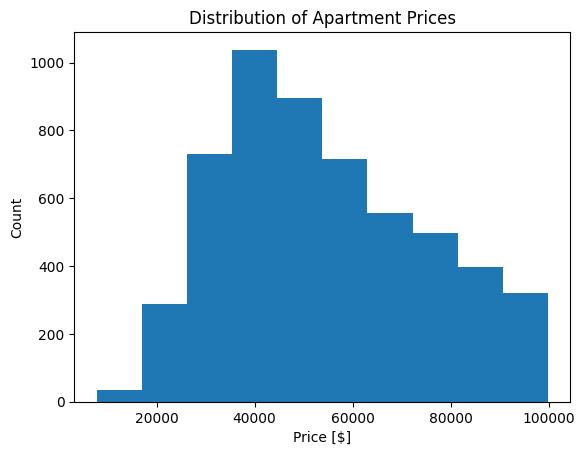

In [26]:
# Build histogram
plt.hist(df["price_aprox_usd"])


# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")
# Add title
plt.title("Distribution of Apartment Prices");


from the histogram we can see that the prices of apartment are skewed to the right(positively).which means that the majority of the data is clustered on the left side of the distribution and the mean is typically greater than the median

In [27]:
# to show that mean is greater than the median.
df["price_aprox_usd"].describe()

count     5473.000000
mean     54246.531498
std      20548.241020
min       7823.940000
25%      38285.520000
50%      50930.230000
75%      68861.230000
max      99864.560000
Name: price_aprox_usd, dtype: float64

Now i will  create a scattered plot  to show apartment price as a function of apartment size, to see if there is a covariance between the two variables.

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

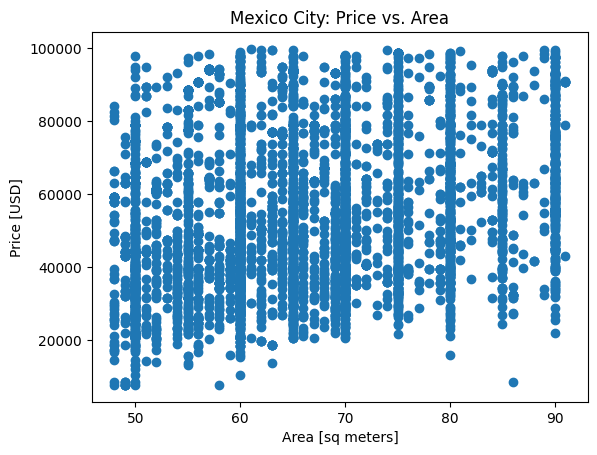

In [28]:
# Build scatter plot
plt.scatter(x=(df["surface_covered_in_m2"]),y=(df["price_aprox_usd"]))


# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")

# Add title
plt.title("Mexico City: Price vs. Area")


Now i will further calculate the correlation between both variables to comfirm its relationship.

In [29]:
# to calculate correlation coefficient
corr = df["surface_covered_in_m2"].corr(df["price_aprox_usd"])
print("Correlation coefficient:", corr)

Correlation coefficient: 0.2763163303635239


From the above diagram and correlation coefficient ,we can see that  there is a positive relationship between the two variables, but it is relatively weak.

# split

  Now i will Create my feature matrix X and target vector y. the target is "price_aprox_usd". Your features are all the columns that remain in the DataFrame I cleaned above.

In [30]:
# Split data into feature matrix `X_train` and target vector `y_train`.
target = "price_aprox_usd"
features = ["surface_covered_in_m2","lat","lon","borough"]
X = df[features]
y = df[target]

# split the data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 


# Build Model

## Baseline

In [31]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae =  mean_absolute_error(y_train,y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54383.042601644585
Baseline MAE: 17189.617520327247


## Iterate

  Next i Create a pipeline named model that contains all the transformers necessary for this dataset and one of the predictors I used during this project. Then  I will fit my  model to the training data.

In [32]:
# Build Model
model = make_pipeline(
     OneHotEncoder(use_cat_names=True),
     SimpleImputer(),
     Ridge()

)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

# Evaluate

 Next i will Read the test data into a data frame and obtain the performance of my model with it.

In [33]:
# making prediction on the test data
y_test_pred = pd.Series(model.predict(X_test))

# calculate the mean absolute error of the test data 
mae_testing = mean_absolute_error(y_test, y_test_pred)
print("Training MAE:", round(mae_testing, 2))

Training MAE: 15200.25


# Communicate Results

Create a Series named feat_imp

In [34]:
coefficients =  model.named_steps["ridge"].coef_
features = model.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.Series(coefficients, index=features)
feat_imp.abs().sort_values()

surface_covered_in_m2               282.608340
borough_Xochimilco                  483.257779
lat                                 885.350311
borough_Iztacalco                   961.817925
borough_Cuauhtémoc                 1246.237298
borough_Miguel Hidalgo             1937.515193
borough_Azcapotzalco               1988.526258
lon                                2451.438015
borough_Álvaro Obregón             2694.959313
borough_Coyoacán                   3101.566307
borough_La Magdalena Contreras     4056.135823
borough_Venustiano Carranza        4744.686435
borough_Gustavo A. Madero          7173.193649
borough_Tlalpan                   10689.861171
borough_Cuajimalpa de Morelos     11876.779993
borough_Iztapalapa                13340.841584
borough_Benito Juárez             13632.729427
borough_Tláhuac                   13915.767167
dtype: float64

Next i will  Create a horizontal bar chart that shows the 10 most influential coefficients for my model.

Text(0.5, 1.0, 'Feature Importances for Apartment Price')

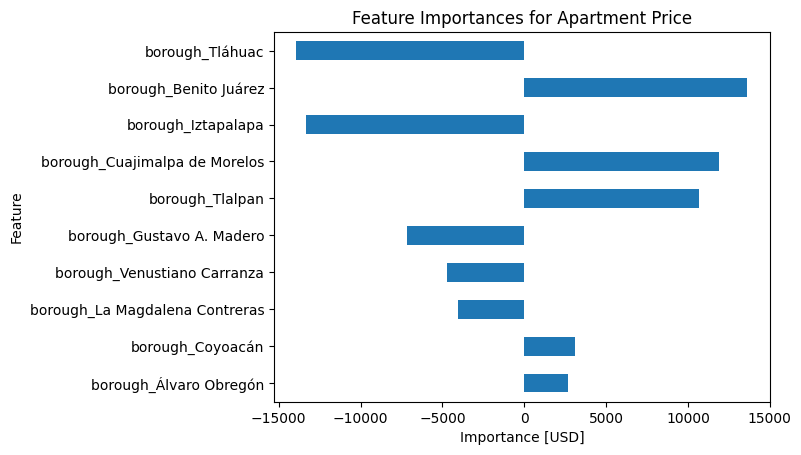

In [35]:
# Build bar chart
feat_imp.sort_values(key=abs).tail(10).plot(kind="barh")


# Label axes
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
# Add title
plt.title("Feature Importances for Apartment Price")

Next i will  Create a function make_prediction that takes four arguments (area, lat, lon, and borough) and returns your model's prediction for an apartment price.

In [36]:
def make_prediction(area, lat, lon, borough):
    data = {
        "surface_covered_in_m2": area,
        "lat":lat,
        "lon":lon,
        "borough": borough
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

## Test

In [37]:
make_prediction(60.0,19.50,-99.20,"Azcapotzalco")

'Predicted apartment price: $53570.17'

Next i create a dash board for interaction

In [38]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    borough=Dropdown(options=sorted(X_train["borough"].unique())),
);

interactive(children=(IntSlider(value=66, description='area', max=91, min=48), FloatSlider(value=19.4563109732…

we just created an interactive dash board where users can hover and gain results on prices of appartment based on  some given features.Even though there are some limitations to the dash board , this is a huge  step in creating and communicationg data driven results to the audience.